In [1]:
import os
import json
from json import JSONDecodeError
import sys
import elasticsearch
import warnings
from sklearn import metrics
sys.path.insert(0, '/home/guinzburg/NLP/Data')
from data_parser import parse_queries, parse_documents, parse_data_ground_truth
import ml_metrics 
import pandas as pd

K = 50
default_b = 0.75
default_k1 = 1.2 
index_name = "document"

## ElasticSearch
Full-text search queries and performs linguistic searches against documents. It includes single or multiple words or phrases and returns documents that match search condition.

ElasticSearch is a search engine based on Apache Lucene, a free and open-source information retrieval software library. It provides a distributed, full-text search engine with an HTTP web interface and schema-free JSON documents.

Documents are represented as JSON objects. JSON serialization is supported by most programming languages and has become the standard format used by the NoSQL movement. It is simple, concise, and easy to read.

https://www.baeldung.com/elasticsearch-full-text-search-rest-api

## Documents, Queries, and Ground Truth
Load the files containing queries, documents and ground truth using 'parse_queries', 'parse_documents', and parse_data_ground_truth, then create json objects for each one
for further processing

In [2]:
# Get all queries
queries = json.loads(json.dumps(parse_queries(path='/home/guinzburg/NLP/Data/CISI.QRY'), indent = 4))
# Get all documents
documents = json.loads(json.dumps(parse_documents(path='/home/guinzburg/NLP/Data/CISI.ALL'), indent = 4))
# Get ground truth
ground_truth = json.loads(json.dumps(parse_data_ground_truth(path='/home/guinzburg/NLP/Data/CISI.REL'), indent = 4))

## Validate ElasticSearch service is up and running
By instantiate a client instance and using an API callcall' in this example `info()` we can validate that the service is running properly <br><br>
<i>Plain vanilla curl command: curl -XGET 'http://localhost:9200/</i>

In [3]:
try:
    es = elasticsearch.Elasticsearch("http://localhost:9200")
    print("ElasticSearch service is up and running.","\nVersion:", es.info()['version']['number'])
except elasticsearch.ElasticsearchException as e:
    print("ElasticSearch service is not running.\n")

ElasticSearch service is up and running. 
Version: 7.15.0


/home/guinzburg/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


## Updating ElasticSearch with Documents
ElasticSearch is document oriented. It stores and indexes documents. Indexing creates or updates documents. After indexing, you can search, sort, and filter complete documents. Using ElasticSearch.index<br><br>
<i>Plain vanilla curl command: 
curl -XPUT 'localhost:9200/text/article/1?pretty'
-H 'Content-Type: application/json' -d '
{
  "title": "He went",
  "random_text": 
    "He went such dare good fact. The small own seven saved man age."
}</i>

In [5]:
for id in documents:
    
    # Create document 
    document = {
        "title": documents[id]['title'],
        "text": documents[id]['body']
    }

    # Use ElasticSearch client to insert a document
    res = es.index(index=index_name, id=id, document=document)
    
    # Verify update was sucessful
    try:
        _ = res['result']

    except elasticsearch.ElasticsearchException as e:
        print("Update error", "Document ID:", id, "Actual Error:", e)

## Count ElasticSearch Documents
Get the number of documents within ElasticSearch using ElasticSearch.count<br><br>
<i>plain vanilla curl command:"curl -XGET 'localhost:9200/document/_count?pretty'</i>

In [6]:
es_doc_count = es.count(index=index_name, body = dict())['count']

print(f"{es_doc_count} / {len(documents)} documents were UPDATED")

1460 / 1460 documents were UPDATED


## Search ElasticSearch for Documents
Get all documents hits that match'es the query defined in the request using ElasticSearch.search<br><br>
<i>plain vanilla curl command: 
curl -XGET 'localhost:9200/text/article/_search?pretty' 
-H 'Content-Type: application/json' -d '
{
  "query": {
    "match": {
      "random_text": "him departure"
    }
  }
}'</i>

In [7]:
def search_elastic():
    
    # create a Python dictionary for the search query:
    queries_response = {}

    for q_id in queries:
        if q_id in list(ground_truth.keys()):
            # Prepare query 
            max_to_search = min(K, len(ground_truth[q_id])) # each query has different number of relevant documents
            search_param = {
                  "size" : f"{max_to_search}",
                  "query": {
                      "simple_query_string" : {
                          "query": queries[q_id] 
            }}}

            # Get a response from the cluster
            response = es.search(index=index_name, body=search_param)

            # Save all results (documents ID's) for each query
            queries_response[q_id] = []
            for item in response['hits']['hits']:
                queries_response[q_id].append((item['_id'], item['_score']))
    
    return queries_response

## Precision and Recall
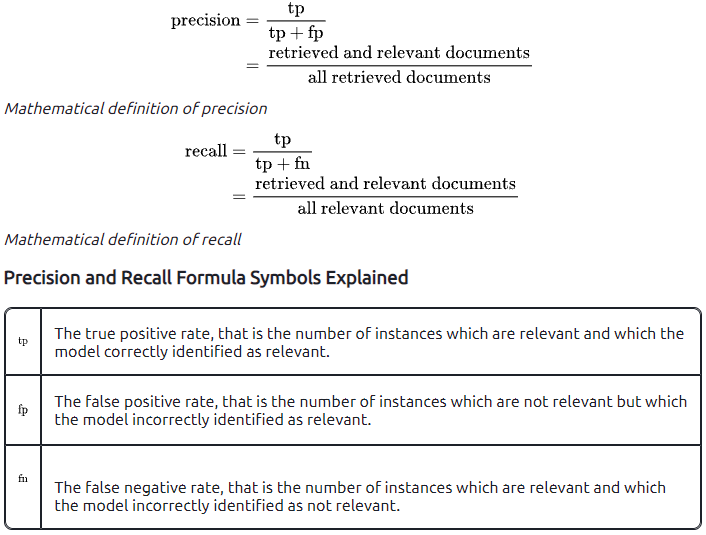

In [8]:
def measure_p_and_r():

    queries_precision_recall = {}
    total_c = 0

    def common(a, b): 
        c = [value for value in a if value in b] 
        return c

    for q_id in queries_response:
        if q_id not in queries_precision_recall.keys():
            queries_precision_recall[q_id] = {}

        # find the intersection between retrieved and relevant documents
        c = common(ground_truth[q_id], [item[0] for item in queries_response[q_id]])
        total_c += len(c)

        # calcualte precision
        queries_precision_recall[q_id]["precision"] = len(c) / len(queries_response[q_id])
        # calcualte recall
        queries_precision_recall[q_id]["recall"] = len(c) / len(ground_truth[q_id])
        
    return queries_precision_recall, total_c

## Calculating mean Average Precision (mAP)

In [50]:
def mean_avg_pre():
    
    actual = []
    predicted = []
    all_recall = []

    for q_id in queries_response:
        q_ground_truth = ground_truth[q_id]
        q_retrived_docs = [item[0] for item in queries_response[q_id]]

        actual.append(q_ground_truth)
        predicted.append(q_retrived_docs)

        all_recall.append(queries_precision_recall[f"{q_id}"]["recall"])

    return ml_metrics.mapk(actual, predicted, 1)

## Calculating Recall

In [51]:
def rec(total_c):

    sum_ground_truth = 0
    for q_id in ground_truth:
        sum_ground_truth += len(ground_truth[q_id])
    return total_c / sum_ground_truth

## Test

In [52]:
def search_for_query(q_id):
    
    return (queries[f"{q_id}"],
            ground_truth[f"{q_id}"],
            [item[0] for item in queries_response[f"{q_id}"]],
            queries_precision_recall[f"{q_id}"]["precision"],
            queries_precision_recall[f"{q_id}"]["recall"])


queries_response = search_elastic()
queries_precision_recall, total_c = measure_p_and_r()
mean_a_p = mean_avg_pre()
rec = rec(total_c)

q_id = "50"
query_results = search_for_query(q_id)
print("-----", f"Query ID {q_id}:\n", query_results[0])
print("\n-----", "Relevant Documents:\n", query_results[1])
print("\n-----", "Retrived Documents:\n",  query_results[2])
print("Precision:", query_results[3])
print("Recall:", query_results[4])

print("\n\n-----Summary-----")
print("Mean Average Precision:", mean_a_p)
print("Recall:", mean_a_r)

<ipython-input-7-55f7e11f2a6c>:18: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  response = es.search(index=index_name, body=search_param)


----- Query ID 50:
 Is there any use for traditional classification schemes - DDC, UDC, LC, etc. - in information retrieval systems? If there is, which scheme appears most suited to machine use and where has it been applied? If there is not, why are these classification schemes irrelevant? Has research shown that a subject classification of knowledge is completely unnecessary in machine systems? Or, have new schemes been devised which appear to be more suited to machine use?

----- Relevant Documents:
 ['1', '16', '45', '80', '154', '209', '257', '258', '259', '260', '262', '263', '275', '276', '333', '334', '335', '342', '354', '361', '388', '404', '480', '488', '522', '527', '530', '564', '576', '596', '608', '701', '702', '758', '769', '797', '801', '817', '820', '825', '830', '838', '853', '868', '869', '884', '898', '931', '960', '966', '989', '993', '996', '999', '1010', '1066', '1072', '1074', '1075', '1103', '1137', '1140', '1141', '1170', '1202', '1215', '1216', '1230', '1231'

## Tuning Hyperparameters b and k1 for BM25 Similarity Module

https://www.elastic.co/blog/practical-bm25-part-3-considerations-for-picking-b-and-k1-in-elasticsearch

In [24]:
import numpy as np
from itertools import permutations, repeat

open_index = "curl -X POST -H \"Content-Type: application/json\" localhost:9200/document/_open"
close_index = "curl -X POST -H \"Content-Type: application/json\" localhost:9200/document/_close"

b = (0, 1)
k1 = (0, 3)
b = np.arange(b[0], b[1], (b[1]-b[0])/3).tolist()
k1 = np.arange(k1[0], k1[1], (k1[1]-k1[0])/3).tolist()
l = list(list(zip(r, p)) for (r, p) in zip(repeat(b), permutations(k1)))

result_list = []
q_id = "50"

for i in range(len(l)):
    for j in range(len(l[i])):
        b_to_set = l[i][j][0]
        k1_to_set = l[i][j][1]
        
        # prepare update message with cusom b and k1 values
        update_index = "curl -X PUT -H \"Content-Type: application/json\" localhost:9200/document/_settings/?pretty=true -d '{ \"settings\": { \"similarity\": { \"bm25-inverse-zero\": { \"type\": \"BM25\", \"b\": \"%s\", \"k1\": \"%s\" }}}}'" % (b_to_set, k1_to_set)
        
        # close index so it can be edited
        close_msg = json.loads(os.popen(close_index).read())
        if close_msg['acknowledged'] != True:
            break
                
        # edit index settings
        update_msg = json.loads(os.popen(update_index).read())
        if close_msg['acknowledged'] != True:
            break
            
        # open index so it can be queried
        open_msg = json.loads(os.popen(open_index).read())
        if open_msg['acknowledged'] != True:
            break   
            
        queries_response = search_elastic()
        queries_precision_recall, total_c = measure_p_and_r()
        mean_a_p = mean_avg_pre()
        mean_a_r = mean_avg_rec(total_c)

        query_results = search_for_query(q_id)
        
        result_list.append((b_to_set,
                            k1_to_set,
                            queries_response, 
                            queries_precision_recall, 
                            mean_a_p, 
                            mean_a_r, 
                            q_id, 
                            query_results))  

<ipython-input-7-55f7e11f2a6c>:18: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  response = es.search(index=index_name, body=search_param)


In [25]:
b_values = []
k1_values = []
mean_a_p_values = []
mean_a_r_values = []
for item in result_list:
    b_values.append(item[0])
    k1_values.append(item[1])
    mean_a_p_values.append(item[4])
    mean_a_r_values.append(item[5])
    
df = pd.DataFrame({'b': b_values, 'k1': k1_values, 'mean average precision': mean_a_p_values, 'recall': mean_a_r_values})

<ipython-input-48-fdbcfedb38dd>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


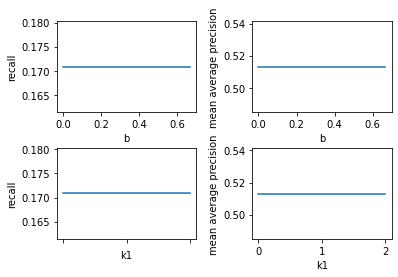

In [48]:
# import the seaborn library
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.lineplot(x=df['b'], y=df['recall'])
ax = fig.add_subplot(2, 2, 2)
sns.lineplot(x=df['b'], y=df['mean average precision'])
ax = fig.add_subplot(2, 2, 3)
sns.lineplot(x=df['k1'], y=df['recall'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = fig.add_subplot(2, 2, 4)
sns.lineplot(x=df['k1'], y=df['mean average precision'])
plt.show()

<AxesSubplot:>

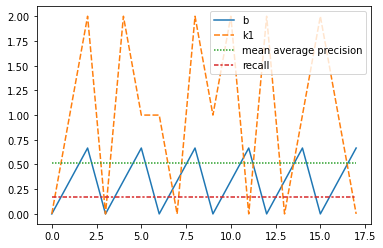

In [46]:
plt.clf()
sns.lineplot(data=df)